# Settings

In [1]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import tensorflow as tf
import numpy.random as rnd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data

In [2]:
import pickle
import boto3
from io import BytesIO

In [3]:
s3 = boto3.resource('s3')
data_subsets = ['train', 'val']
data = {}

for name in data_subsets:
    with BytesIO() as files:
        path = "omniglot_images/" +name+ ".pickle"
        s3.Bucket("research-paper-omniglot-data").download_fileobj(path, files)
        files.seek(0)    # move back to the beginning after writing
        (X,c) = pickle.load(files)
        data[name] = X

path = '../../omniglot_images/'
data_subsets = ["train", "val", "test"]

data = {}
categories = {}
info = {}
        
for name in data_subsets:
    file_path = os.path.join(path, name + ".pickle")
    print("loading data from {}".format(file_path))
    with open(file_path,"rb") as f:
        (X,c) = pickle.load(f)
        data[name] = X
        categories[name] = c

In [4]:
def create_train_data(size, s='train'):
    #get train data and shape
    X=data[s]
    n_classes, n_examples, w, h = X.shape
    
    #initialize 2 empty arrays for the input size in a list
    pairs=[np.zeros((size, h, w,1)) for i in range(2)]
    
    #initialize vector for the targets
    targets=np.zeros((size,1))
    
    for x in range(size):
        #randomly sample one class (character)
        category = rnd.choice(n_classes,1,replace=False)
        #randomly sample one example from class (1-20 characters)
        idx_1 = rnd.randint(0, n_examples)
        pairs[0][x,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        #randomly sample again one example from class and add last class with modulo
        # ..to ensure not same class pairs are created
        idx_2 = (idx_1 + rnd.randint(0, n_examples)) % n_examples
        #pick images of different class for 1st half and same class for 2nd half
        if x >= size // 2:
            category_2 = category
            targets[x] = 1
        else: 
        #add a random number to the category modulo n classes to ensure 2nd image has
        # ..different category
            idx_2 = rnd.randint(0, n_examples) 
            category_2 = (category + rnd.randint(1,n_classes)) % n_classes
            targets[x] = 0
        pairs[1][x,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
        
    return pairs, targets

In [5]:
train_set, train_labels = create_train_data(10000)
val_set, val_labels = create_train_data(3000, s='val')

# Hyperparameter setting

In [6]:
dim_learning_rate = Real(low=1e-7, high=0.1, prior='log-uniform', name='learning_rate')
dim_reg_layer1 = Real(low=0.00000001, high=0.1, prior='log-uniform', name='reg_layer1')
dim_reg_layer2 = Real(low=0.00000001, high=0.1, prior='log-uniform', name='reg_layer2')
dim_reg_layer3 = Real(low=0.00000001, high=0.1, prior='log-uniform', name='reg_layer3')
dim_reg_layer4 = Real(low=0.00000001, high=0.1, prior='log-uniform', name='reg_layer4')
dim_reg_layer5 = Real(low=0.00000001, high=0.1, prior='log-uniform', name='reg_layer5')
dim_filt_layer1 = Integer(4,12, name='filter_layer1')
dim_filt_layer2 = Integer(8,12, name='filter_layer2')
dim_filt_layer3 = Integer(5,8, name='filter_layer3')
dim_filt_layer4 = Integer(2,5, name='filter_layer4')
dim_chan_layer1 = Categorical([16,32,48,64,80,96], name='channel_layer1')
dim_chan_layer2 = Categorical([16,32,48,64,80,96,112,128], name='channel_layer2')
dim_chan_layer3 = Categorical([16,32,48,64,80,96,112,128,144,160], name='channel_layer3')
dim_chan_layer4 = Categorical([16,32,48,64,80,96,112,128,144,160,176,192], name='channel_layer4')
dim_fc_layer5 = Categorical([256,512,768,1024,1280,1536,1792,2048,2304,2560,2816,3072], name='channel_layer5')
beta1 = Real(low=0.00001, high=0.9999, prior = 'uniform', name='beta1')
beta2 = Real(low=0.00001, high=0.9999, prior = 'uniform', name='beta2')
batch = Categorical([32,48], name='batch')

In [7]:
dimensions = [dim_learning_rate,
             dim_reg_layer1,
             dim_reg_layer2,
             dim_reg_layer3,
             dim_reg_layer4,
             dim_reg_layer5,
             dim_filt_layer1,
             dim_filt_layer2,
             dim_filt_layer3,
             dim_filt_layer4,
             dim_chan_layer1,
             dim_chan_layer2,
             dim_chan_layer3,
             dim_chan_layer4,
             dim_fc_layer5,
             beta1,
             beta2,
             batch]

In [8]:
default_parameters = [8.824e-05,1e-08,1.327e-08,1e-08,5.0997e-05,1e-08,6,10,8,3,64,32,96,160,2560,0.739,0.9999,32]

# Create graph

In [9]:
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rnd.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)

In [10]:
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rnd.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

In [11]:
def create_network(**params):
    input_shape = (105, 105, 1)
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    #build convnet to use in each siamese 'leg'
    convnet = Sequential()
    convnet.add(Conv2D(params['channel_layer1'],(params['filter_layer1'],params['filter_layer1']),activation='relu',input_shape=input_shape,kernel_initializer=W_init,kernel_regularizer=l2(params['reg_layer1']),bias_initializer=b_init))
    convnet.add(MaxPooling2D())
    convnet.add(Conv2D(params['channel_layer2'],(params['filter_layer2'],params['filter_layer2']),activation='relu',kernel_regularizer=l2(params['reg_layer2']),kernel_initializer=W_init,bias_initializer=b_init))
    convnet.add(MaxPooling2D())
    convnet.add(Conv2D(params['channel_layer3'],(params['filter_layer3'],params['filter_layer3']),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(params['reg_layer3']),bias_initializer=b_init))
    convnet.add(MaxPooling2D())
    convnet.add(Conv2D(params['channel_layer4'],(params['filter_layer4'],params['filter_layer4']),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(params['reg_layer4']),bias_initializer=b_init))
    convnet.add(Flatten())
    convnet.add(Dense(params['channel_layer5'],activation="sigmoid",kernel_regularizer=l2(params['reg_layer5']),kernel_initializer=W_init,bias_initializer=b_init))
    #call the convnet Sequential model on each of the input tensors so params will be shared
    encoded_l = convnet(left_input)
    encoded_r = convnet(right_input)
    #layer to merge two encoded inputs with the l1 distance between them
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    #call this layer on list of two input tensors.
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    optimizer = Adam(lr=params['learning_rate'], beta_1=params['beta1'], beta_2=params['beta2'])
    siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)
    #siamese_net.count_params()
    return(siamese_net)

In [12]:
def accuracy(pred, true_val):
    acc_bool = np.equal(np.round_(pred), true_val)
    acc = np.mean(acc_bool.astype(int))
    
    return(acc)

# Training

This is just as fast as the Tensorflow implementation

In [13]:
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))
###################################


@use_named_args(dimensions=dimensions)
def fitness(**params):
    #Training loop
    siamese_net = create_network(**params)
        
    print("!")
    batch_size = params['batch']
    total_batch = int(10000/batch_size)
    total_batch_val = int(3000/batch_size)
    epoch = 10
    print("training")
    val_batch_acc = 0
    val_acc = 0
    for i in range(epoch):
        #train_batch_acc = 0
        for j in range(total_batch):
            batch_x1, batch_x2, batch_y = shuffle(train_set[0],train_set[1], train_labels, n_samples = batch_size)
            loss=siamese_net.train_on_batch([batch_x1, batch_x2],batch_y)
            #probs = siamese_net.predict([batch_x1, batch_x2])
            #train_batch_acc += accuracy(probs, batch_y)
            #print('Loss:', loss)
            #print('Batch:', j)
        #train_acc = train_batch_acc/total_batch
        if i == epoch - 1:
            for validation in range(total_batch_val):
                batch_x1, batch_x2, batch_y = shuffle(val_set[0],val_set[1], val_labels, n_samples = batch_size)
                probs = siamese_net.predict([batch_x1, batch_x2])
                val_batch_acc += accuracy(probs, batch_y)
            val_acc = val_batch_acc/total_batch_val
            print('Validation accuracy:', val_acc)
        print('Epoch:', i)
        #print('Train accuracy:', train_acc)
    return(-val_acc)

In [17]:
fitness(x=default_parameters)

!
training
Loss: 4.4984665
Batch: 0
Loss: 4.403412
Batch: 1
Loss: 4.330426
Batch: 2
Loss: 4.24168
Batch: 3
Loss: 4.1520605
Batch: 4
Loss: 4.066664
Batch: 5
Loss: 3.988257
Batch: 6
Loss: 3.9156978
Batch: 7
Loss: 3.8498886
Batch: 8
Loss: 3.791628
Batch: 9
Loss: 3.7408202
Batch: 10
Loss: 3.6968129
Batch: 11
Loss: 3.658761
Batch: 12
Loss: 3.6255662
Batch: 13
Loss: 3.5960796
Batch: 14
Loss: 3.5691466
Batch: 15
Loss: 3.5438907
Batch: 16
Loss: 3.5197856
Batch: 17
Loss: 3.496443
Batch: 18
Loss: 3.4735928
Batch: 19
Loss: 3.4510489
Batch: 20
Loss: 3.4286983
Batch: 21
Loss: 3.4064739
Batch: 22
Loss: 3.384332
Batch: 23
Loss: 3.3622463
Batch: 24
Loss: 3.3402033
Batch: 25
Loss: 3.318196
Batch: 26
Loss: 3.2962224
Batch: 27
Loss: 3.2742836
Batch: 28
Loss: 3.252379
Batch: 29
Loss: 3.2305143
Batch: 30
Loss: 3.2086942
Batch: 31
Loss: 3.186924
Batch: 32
Loss: 3.165208
Batch: 33
Loss: 3.1435518
Batch: 34
Loss: 3.121961
Batch: 35
Loss: 3.10044
Batch: 36
Loss: 3.078994
Batch: 37
Loss: 3.0576262
Batch: 38
Los

Loss: 1.2194717
Batch: 77
Train accuracy: 0.9955929487179487
Validation accuracy: 0.681046195652174
Loss: 2.047232
Batch: 0
Loss: 1.6528767
Batch: 1
Loss: 1.3625965
Batch: 2
Loss: 1.2733976
Batch: 3
Loss: 1.2483989
Batch: 4
Loss: 1.2347552
Batch: 5
Loss: 1.218029
Batch: 6
Loss: 1.2065902
Batch: 7
Loss: 1.198956
Batch: 8
Loss: 1.192144
Batch: 9
Loss: 1.1861367
Batch: 10
Loss: 1.1815007
Batch: 11
Loss: 1.1777263
Batch: 12
Loss: 1.1742325
Batch: 13
Loss: 1.1709801
Batch: 14
Loss: 1.1680155
Batch: 15
Loss: 1.1651844
Batch: 16
Loss: 1.1623319
Batch: 17
Loss: 1.1594843
Batch: 18
Loss: 1.1567261
Batch: 19
Loss: 1.154084
Batch: 20
Loss: 1.1515338
Batch: 21
Loss: 1.1490407
Batch: 22
Loss: 1.146579
Batch: 23
Loss: 1.144134
Batch: 24
Loss: 1.1416973
Batch: 25
Loss: 1.1392659
Batch: 26
Loss: 1.136837
Batch: 27
Loss: 1.1344097
Batch: 28
Loss: 1.1319836
Batch: 29
Loss: 1.1295587
Batch: 30
Loss: 1.1271353
Batch: 31
Loss: 1.1247138
Batch: 32
Loss: 1.1222942
Batch: 33
Loss: 1.1198772
Batch: 34
Loss: 1.

Loss: 0.6660321
Batch: 69
Loss: 0.66471463
Batch: 70
Loss: 0.66340005
Batch: 71
Loss: 0.66208804
Batch: 72
Loss: 0.6607786
Batch: 73
Loss: 0.6594721
Batch: 74
Loss: 0.65816814
Batch: 75
Loss: 0.6568668
Batch: 76
Loss: 0.6555682
Batch: 77
Train accuracy: 0.9983974358974359
Validation accuracy: 0.7088994565217391
Loss: 1.185165
Batch: 0
Loss: 0.92216676
Batch: 1
Loss: 0.74742746
Batch: 2
Loss: 0.7317742
Batch: 3
Loss: 0.7031685
Batch: 4
Loss: 0.68872476
Batch: 5
Loss: 0.68291694
Batch: 6
Loss: 0.6806782
Batch: 7
Loss: 0.6785071
Batch: 8
Loss: 0.674973
Batch: 9
Loss: 0.67100304
Batch: 10
Loss: 0.6676639
Batch: 11
Loss: 0.665144
Batch: 12
Loss: 0.66321176
Batch: 13
Loss: 0.6616208
Batch: 14
Loss: 0.6601999
Batch: 15
Loss: 0.6588511
Batch: 16
Loss: 0.657523
Batch: 17
Loss: 0.6561891
Batch: 18
Loss: 0.6548443
Batch: 19
Loss: 0.6534978
Batch: 20
Loss: 0.65216553
Batch: 21
Loss: 0.6508656
Batch: 22
Loss: 0.6496026
Batch: 23
Loss: 0.6483559
Batch: 24
Loss: 0.6471102
Batch: 25
Loss: 0.6458692
Ba

-0.7238451086956522

In [14]:
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=60,
                            x0=default_parameters,
                           verbose=True)

Iteration No: 1 started. Evaluating function at provided point.
!
training
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Validation accuracy: 0.8356854838709677
Epoch: 9
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 67.5356
Function value obtained: -0.8357
Current minimum: -0.8357
Iteration No: 2 started. Evaluating function at random point.
!
training
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Validation accuracy: 0.5047043010752688
Epoch: 9
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 99.9424
Function value obtained: -0.5047
Current minimum: -0.8357
Iteration No: 3 started. Evaluating function at random point.
!
training
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Validation accuracy: 0.7207661290322581
Epoch: 9
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 94.2459
Function value obtained: -0.7208
Current mi

!
training
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Validation accuracy: 0.4946236559139785
Epoch: 9
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 65.8027
Function value obtained: -0.4946
Current minimum: -0.8427
Iteration No: 26 started. Searching for the next optimal point.
!
training
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Validation accuracy: 0.5903897849462365
Epoch: 9
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 83.6021
Function value obtained: -0.5904
Current minimum: -0.8427
Iteration No: 27 started. Searching for the next optimal point.
!
training
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Validation accuracy: 0.49731182795698925
Epoch: 9
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 121.1559
Function value obtained: -0.4973
Current minimum: -0.8427
Iteration

Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 83.2670
Function value obtained: -0.5192
Current minimum: -0.8438
Iteration No: 49 started. Searching for the next optimal point.
!
training
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Validation accuracy: 0.7799059139784946
Epoch: 9
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 93.5671
Function value obtained: -0.7799
Current minimum: -0.8438
Iteration No: 50 started. Searching for the next optimal point.
!
training
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Validation accuracy: 0.8145161290322581
Epoch: 9
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 80.1725
Function value obtained: -0.8145
Current minimum: -0.8438
Iteration No: 51 started. Searching for the next optimal point.
!
training
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch

In [15]:
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

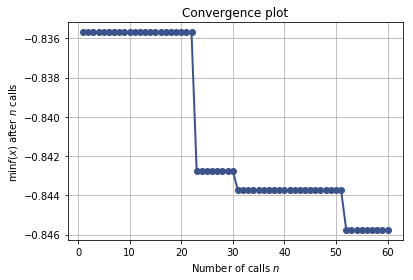

In [16]:
plot_convergence(search_result)

# 60 iterations

In [17]:
sorted(zip(search_result.func_vals, search_result.x_iters))

[(-0.8457661290322579,
  [5.490651011229577e-05,
   1.271441508724827e-06,
   1e-08,
   2.7342798595232468e-05,
   0.005638904645963502,
   0.00048774652028289105,
   5,
   12,
   7,
   2,
   64,
   112,
   96,
   144,
   1536,
   0.5744831333017718,
   0.9999,
   48]),
 (-0.84375,
  [0.00010504113129066549,
   0.00022022031107525204,
   1.3524799530744914e-07,
   1e-08,
   1e-08,
   7.796148534881568e-06,
   11,
   12,
   5,
   4,
   64,
   48,
   112,
   192,
   1024,
   0.27896433738705284,
   0.6468398543538967,
   32]),
 (-0.8430779569892473,
  [9.458575571312315e-05,
   2.9154611653801043e-06,
   1.7328553111633675e-07,
   6.967137793206209e-08,
   4.6208665422528896e-08,
   3.2619665303795646e-06,
   12,
   12,
   8,
   2,
   48,
   48,
   112,
   192,
   2560,
   0.05234801798230036,
   0.9422340814482131,
   32]),
 (-0.8427419354838711,
  [0.00011021598610503274,
   1.486602508822446e-05,
   4.969388186479319e-06,
   0.0011043009424972741,
   4.400839707187273e-06,
   1.657312

# 30 iterations

In [18]:
sorted(zip(search_result.func_vals, search_result.x_iters))

[(-0.8561827956989247,
  [8.8236737270166e-05,
   1e-08,
   1.326725515944222e-08,
   1e-08,
   5.0997369819268274e-05,
   1e-08,
   6,
   10,
   8,
   3,
   64,
   32,
   96,
   160,
   2560,
   0.7391658564044657,
   0.9999,
   32]),
 (-0.854502688172043,
  [6.16251948834497e-05,
   1e-08,
   1.0347315112413696e-08,
   1e-08,
   1.7225817253935858e-06,
   2.5356671661874186e-06,
   6,
   10,
   8,
   4,
   64,
   144,
   96,
   160,
   1280,
   0.6460780723554685,
   0.9999,
   32]),
 (-0.8417338709677419,
  [9.249516740964438e-05,
   1.65645672799752e-06,
   2.0212983450054314e-06,
   5.9559985830515796e-05,
   0.00474768850969449,
   3.9520792545822195e-08,
   7,
   8,
   8,
   3,
   16,
   32,
   96,
   160,
   2560,
   0.28086501184972806,
   0.9788445622478666,
   32]),
 (-0.8373655913978495,
  [5.859434388146192e-05,
   0.008785894138915515,
   2.03421259226207e-05,
   0.1,
   2.1067419920481055e-06,
   0.001562306081019681,
   9,
   5,
   3,
   3,
   64,
   16,
   128,
   256,

In [19]:
search_result.x

[8.8236737270166e-05,
 1e-08,
 1.326725515944222e-08,
 1e-08,
 5.0997369819268274e-05,
 1e-08,
 6,
 10,
 8,
 3,
 64,
 32,
 96,
 160,
 2560,
 0.7391658564044657,
 0.9999,
 32]